# Pre-load

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import re
import eelbrain
import mne
import trftools

In [2]:
STIMULI = [str(i) for i in range(1, 12)]
DATA_ROOT = Path("~").expanduser() / 'Data' / 'LittlePrince'
PREDICTOR_DIR = DATA_ROOT / 'predictors'
EEG_DIR = DATA_ROOT / 'eeg'
#SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'S\d*', path.name)]
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs'
TRF_DIR.mkdir(exist_ok=True)

In [3]:
# Load stimuli
# ------------
# Make sure to name the stimuli so that the TRFs can later be distinguished
# Load the gammatone-spectrograms; use the time axis of these as reference
gammatone = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-8.pickle') for stimulus in STIMULI]

# Resample the spectrograms to 100 Hz (time-step = 0.01 s), which we will use for TRFs
gammatone = [x.bin(0.01, dim='time', label='start') for x in gammatone]

# Pad onset with 100 ms and offset with 1 second; make sure to give the predictor a unique name as that will make it easier to identify the TRF later
gammatone = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='gammatone') for x in gammatone]

# Load the broad-band envelope and process it in the same way
envelope = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-1.pickle') for stimulus in STIMULI]
envelope = [x.bin(0.01, dim='time', label='start') for x in envelope]
envelope = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope') for x in envelope]
onset_envelope = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-on-1.pickle') for stimulus in STIMULI]
onset_envelope = [x.bin(0.01, dim='time', label='start') for x in onset_envelope]
onset_envelope = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='onset') for x in onset_envelope]

# Load onset spectrograms and make sure the time dimension is equal to the gammatone spectrograms
gammatone_onsets = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-on-8.pickle') for stimulus in STIMULI]
gammatone_onsets = [x.bin(0.01, dim='time', label='start') for x in gammatone_onsets]
gammatone_onsets = [eelbrain.set_time(x, gt.time, name='gammatone_on') for x, gt in zip(gammatone_onsets, gammatone)]

# Load word tables and convert tables into continuous time-series with matching time dimension
#word_tables = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~word.pickle') for stimulus in STIMULI]
#word_onsets = [eelbrain.event_impulse_predictor(gt.time, ds=ds, name='word') for gt, ds in zip(gammatone, word_tables)]

# Function and content word impulses based on the boolean variables in the word-tables
#word_lexical = [eelbrain.event_impulse_predictor(gt.time, value='lexical', ds=ds, name='lexical') for gt, ds in zip(gammatone, word_tables)]
#word_nlexical = [eelbrain.event_impulse_predictor(gt.time, value='nlexical', ds=ds, name='non_lexical') for gt, ds in zip(gammatone, word_tables)]

# Extract the duration of the stimuli, so we can later match the EEG to the stimuli
durations = [gt.time.tmax for stimulus, gt in zip(STIMULI, gammatone)]


In [4]:
# Models
# ------
# Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
models = {
    # Acoustic models
    'envelope': [envelope],
#    'envelope+onset': [envelope, onset_envelope],
#    'acoustic': [gammatone, gammatone_onsets],
    # Models with word-onsets and word-class
#    'words': [word_onsets],
#    'words+lexical': [word_onsets, word_lexical, word_nlexical],
#    'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
#    'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
}

# Load & preprocess EEG

In [5]:
SUBJECTS=['R0443_20170525_LittlePrince', 'R0459_20170616_LittlePrince', 'R0462_20170621_LittlePrince', 'R0481_20171027_LittlePrince']

subject = SUBJECTS[0]
subject_trf_dir = TRF_DIR / subject
subject_trf_dir.mkdir(exist_ok=True)
    
# Generate all TRF paths so we can check whether any new TRFs need to be estimated
trf_paths = {model: subject_trf_dir / f'{subject} {model}.pickle' for model in models}
        
# Load the EEG data
raw = mne.io.read_raw_brainvision(EEG_DIR / subject / f'{subject}EEG_01.vhdr', preload=True)

#raw = mne.io.read_raw_brainvision(f'C:/Dropbox (University of Michigan)/lpp-eeg/{s}/{s}EEG_01.vhdr', preload=True)
#R0420: No S1, R0443: noisy after 553 sec, R0446: noisy, R0454: no S1

In [6]:
# Filter

raw.filter(0.5, 20)

#Rereference

raw.add_reference_channels('29')
raw.set_eeg_reference(ref_channels = ['25', '29'])

# Pick EEG channels

raw=raw.pick_types(eeg=True, meg=False, exclude=['VEOG', 'OPTO', 'AUD'])

# Set montage

montage = mne.channels.read_custom_montage('easycapM10-acti61_elec.sfp')
raw.set_montage(montage, on_missing='ignore')

# Crop
eeg = raw.copy().crop(tmax=600) #462: 650

C:\Users\LG\AppData\Local\Temp\ipykernel_39908\1534926783.py:17: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='ignore')


In [15]:
eeg = raw.copy().crop(tmax=600) #462: 650

In [12]:
#eeg.info['ch_names']

In [25]:
eeg.plot()

In [24]:
#butterfly plot
eeg.pick_types(eeg=True).plot(butterfly=True, start = 0.0, duration = 20.0, scalings = dict(eeg=100e-6));

In [23]:
#eeg.info['bads'].append('9') #R0443[9, 27, 59], R0446[14, 27, 28, 47, 53, 59] #R0459 [14, 15, 19, 24, 28, 53], #R0462 [24, 30, 56, 25, 31]
#eeg.info['bads'].append('26')
#eeg.info['bads'].append('27')
#eeg.info['bads'].append('59')
#eeg.info['bads'].append('28')
#eeg.info['bads'].append('53')
#eeg.info['bads'].append('1')

eeg.interpolate_bads()

<RawBrainVision | R0443_20170525_LittlePrinceEEG_01.eeg, 61 x 300001 (600.0 s), ~139.7 MB, data loaded>

In [30]:
eeg.plot()

In [26]:
filt_raw = eeg.copy().filter(l_freq=1., h_freq=None)
ica = mne.preprocessing.ICA(n_components=25, max_iter='auto', random_state=97)
ica.fit(filt_raw)
ica

Method,fastica
Fit,38 iterations on raw data (288298 samples)
ICA components,25
Explained variance,99.0 %
Available PCA components,61
Channel types,eeg
ICA components marked for exclusion,—


In [20]:
filt_raw.load_data()
ica.plot_sources(filt_raw, show_scrollbars=True);

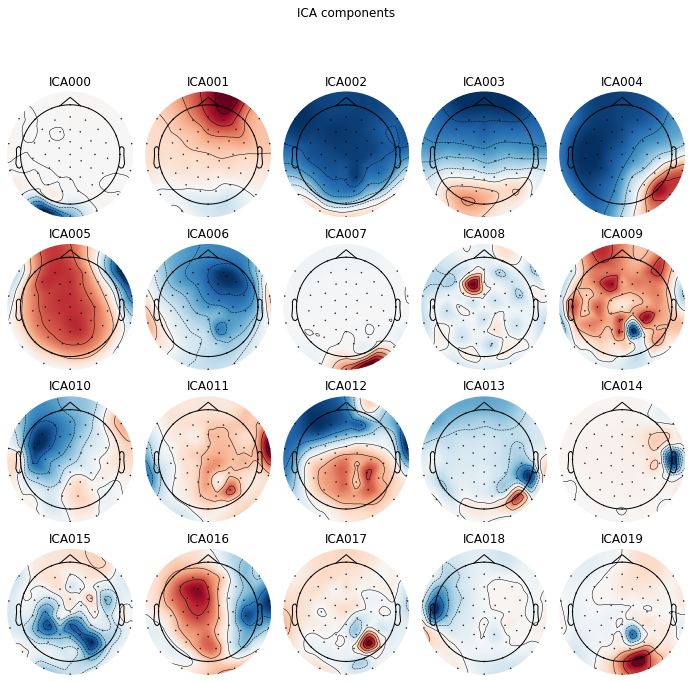

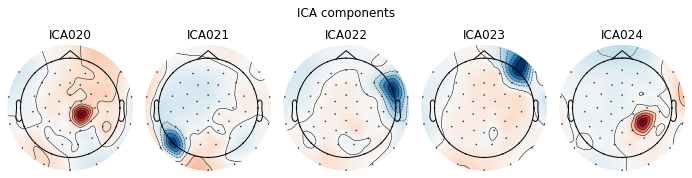

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x187.56 with 5 Axes>]

In [27]:
ica.plot_components()

In [21]:
ica.exclude = [1, 3] #R0443
#ica.exclude = [3, 4] #R0459
#ica.exclude = [0, 1, 2, 4] #R0462
#ica.exclude = [0,2, 4, 6,9] #R0465

ica.apply(eeg)

<RawBrainVision | R0443_20170525_LittlePrinceEEG_01.eeg, 61 x 300001 (600.0 s), ~139.7 MB, data loaded>

In [65]:
eeg.plot()

In [22]:
eeg.pick_types(eeg=True).plot(butterfly=True, start = 0.0, duration = 20.0, scalings = dict(eeg=100e-6));

In [67]:
eeg.save('C:/Users/LG/Data/LittlePrince/eeg/R0443_ref2_preprocessed_raw.fif', overwrite=True)

# Load preprocessed eeg data

In [107]:
#R0443_ref2, R0459_ref, R0462_ref
eeg = mne.io.read_raw('C:/Users/LG/Data/LittlePrince/eeg/R0462_ref_preprocessed_raw.fif')

In [108]:
# Shift
import numpy as np 

shft = 0.37
events = mne.events_from_annotations(eeg);
events = events[0];
events_shft = []

for i in range(len(events)-1):
    events_shft[i:i+1] = mne.event.shift_time_events(events[i:i+1], ids=None, tshift=shft, sfreq=eeg.info['sfreq'])

arr = np.vstack(events_shft)

In [109]:
# Get data from the paragraph onset
event_id={'onset': 1}
events = mne.events_from_annotations(eeg)
events = events[0]
dur = sum(durations)

#epochs = mne.Epochs(eeg, events, event_id, tmin=-0.1, tmax=566.53, baseline=(None,0.), preload=True)
epochs = mne.Epochs(eeg, arr, event_id, tmin=-0.1, tmax=566.53, baseline=(None,0.), preload=True)

#epochs_aud = mne.Epochs(aud, events, event_id, tmin=-0.1, tmax=566.53, baseline=(None,0.), preload=True)

In [110]:
# Resample and concatenate
epoch_downsampled = epochs.copy().resample(sfreq=100)
resp = eelbrain.load.fiff.epochs_ndvar(epoch_downsampled, -0.100, connectivity='auto')
resp_concatenated = eelbrain.concatenate(resp)

In [ ]:
# Predictor_concatenate
trial_indexes = [int(i)-1 for i in STIMULI]
trial_durations = durations

for model, predictors in models.items():
    #path = trf_paths[model]
    # Skip if this file already exists
    #if path.exists():
    #    continue
    #print(f"Estimating: {subject} ~ {model}")

    # Select and concetenate the predictors corresponding to the EEG trials
    predictors_concatenated = []
    for predictor in predictors:
        predictors_concatenated.append(eelbrain.concatenate([predictor[i] for i in trial_indexes]))

In [16]:
X=range(0, 56663)
predictors_concatenated[0].x[X]

array([0., 0., 0., ..., 0., 0., 0.])

In [94]:
resp_concatenated.get_dim('time')

UTS(0.0, 0.01, 56663)

In [101]:
predictors_concatenated[0].get_dim("time") #sampling rate = 100

UTS(0.0, 0.01, 56663)

In [111]:
# Fit the mTRF
eelbrain.configure(n_workers=False)

trf = eelbrain.boosting(resp_concatenated, predictors_concatenated, -0.100, 1.000, error='l1', basis=0.050, partitions=5, test=1, selective_stopping=True)
        
# Save the TRF for later analysis
#eelbrain.save.pickle(trf, path)

Fitting models:   0%|          | 0/1220 [00:00<?, ?it/s]

In [38]:
path

WindowsPath('C:/Users/LG/Data/LittlePrince/TRFs/R0459_20170616_LittlePrince/R0459_20170616_LittlePrince envelope.pickle')

In [96]:
eelbrain.save.pickle(trf, 'C:/Users/LG/Data/LittlePrince/TRFs/R0462 shifted_envelope.pickle')

# Figure

cf. boosting result: https://eelbrain.readthedocs.io/en/stable/generated/eelbrain.BoostingResult.html

In [78]:
import re
import os
import trftools
from scipy.io import loadmat
from eelbrain import *
from matplotlib import pyplot

In [9]:
subject = 'R0462'
trf = load.unpickle(f'C:/Users/LG/data/LittlePrince/TRFs/{subject} shifted_envelope.pickle')

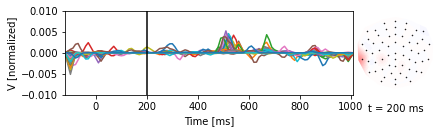

In [112]:
%matplotlib inline
p = plot.TopoButterfly(trf.h, w=6, h=2, vmax = 0.01)
p.set_time(.2)

Prompt-toolkit does not seem to be supported by the current IPython shell (ZMQInteractiveShell); The Eelbrain GUI needs to block Terminal input to work. Use eelbrain.gui.run() to start GUI interaction.
Starting GUI. Quit the Python application to return to the shell...


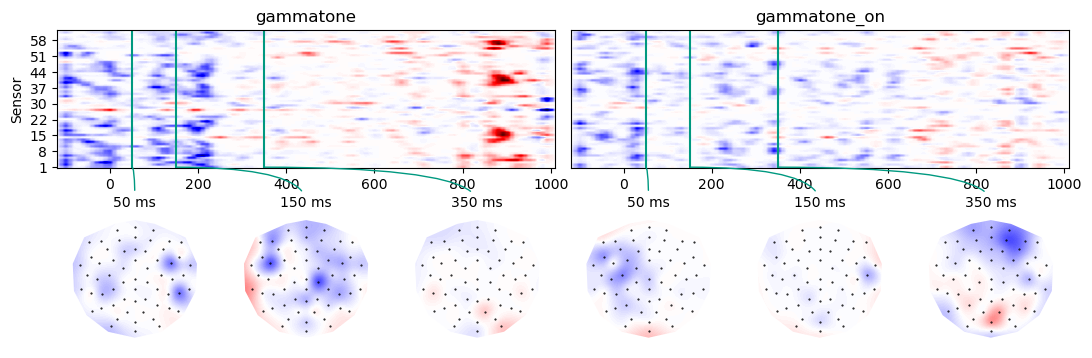

In [48]:
%matplotlib qt
plot.TopoArray(trf.h, w=6, h=2, t=(.050, .150, .350))

In [27]:
trf1 = eelbrain.load.unpickle(Path("~").expanduser() / 'Data' / 'Alice' / 'TRFs' / 'S01' / 'S01 acoustic.pickle')

In [31]:
p = plot.TopoButterfly(trf1.h_scaled, w=6, h=2)
p.set_time(.35)

ValueError: y=<NDVar 'gammatone': 61 sensor, 8 frequency, 114 time> is ambiguous for required dimensions ('sensor', None)

In [ ]:
p = plot.TopoArray(trf1.h, w=6, h=2, t=(.050, .150, .350))

Starting GUI. Quit the Python application to return to the shell...


# AUD channel alignment

In [31]:
# AUD

aud = raw.copy().pick_channels(['AUD'])
aud = aud.crop(tmax=650)

NameError: name 'raw' is not defined

In [ ]:
aud.save(EEG_DIR / f'{subject}aud_raw.fif')

In [18]:
trial_indexes = [int(i)-1 for i in STIMULI]
trial_durations = durations

for model, predictors in models.items():
    #path = trf_paths[model]
    # Skip if this file already exists
    #if path.exists():
    #    continue
    #print(f"Estimating: {subject} ~ {model}")

    # Select and concetenate the predictors corresponding to the EEG trials
    predictors_concatenated = []
    for predictor in predictors:
        predictors_concatenated.append(eelbrain.concatenate([predictor[i] for i in trial_indexes]))

In [113]:
SUBJECTS=['R0443_20170525_LittlePrince', 'R0459_20170616_LittlePrince', 'R0462_20170621_LittlePrince']
subject = SUBJECTS[2]

aud = mne.io.read_raw_fif(EEG_DIR / f'{subject}aud_raw.fif')

In [66]:
# Get data from the paragraph onset
event_id={'onset': 1}
events = mne.events_from_annotations(aud)
events = events[0]
dur = sum(durations)

epochs_aud = mne.Epochs(aud, events, event_id, tmin=-0.1, tmax=566.53, baseline=(None,0.), preload=True)

AttributeError: 'NDVar' object has no attribute 'annotations'

In [114]:
# Shifted data
event_id={'onset': 1}
events = mne.events_from_annotations(eeg)
events = events[0]
dur = sum(durations)

epochs_aud = mne.Epochs(aud, arr, event_id, tmin=-0.1, tmax=566.53, baseline=(None,0.), preload=True)

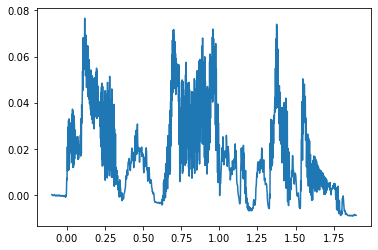

In [100]:
# AUD channel plot
y=epochs_aud.get_data()[0][0][0:1000]
t=epochs_aud.times[0:1000]
plt.plot(t, y)

In [115]:
# Resample and concatenate

epoch_downsampled = epochs_aud.copy().resample(sfreq=100)
aud = eelbrain.load.fiff.epochs_ndvar(epoch_downsampled, -0.100, connectivity='none')
aud_concatenated = eelbrain.concatenate(aud)

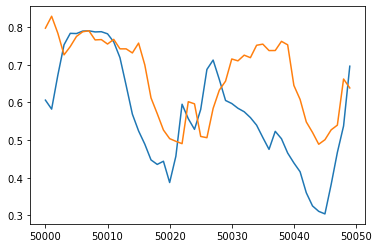

In [122]:
%matplotlib inline
#X = range(0, 50)
X = range(50000, 50050)
plt.plot(X, predictors_concatenated[0].x[X]/2000)
plt.plot(X, aud_concatenated.x[0][X])

plt.show()

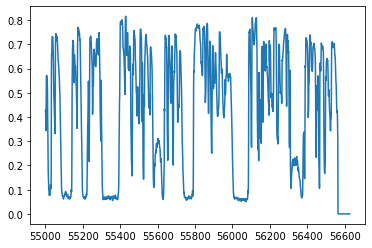

In [45]:
# Envelope plot

X = range(54000, 56000) #120ms = 12 samples
plt.plot(X, predictors_concatenated[0].x[X]/2000) #BLUE

plt.show()

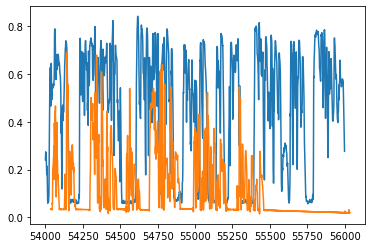

In [101]:
# Resp_concatenated plot

X = range(54000, 56000) #120ms = 12 samples
plt.plot(X, predictors_concatenated[0].x[X]/2000) #BLUE

Y = range(54035,56035) #12 samples = 120ms
plt.plot(Y, aud_concatenated.x[0][Y]) #ORANGE

plt.show()

In [ ]:
aud_concatenated.x[0][40:46]

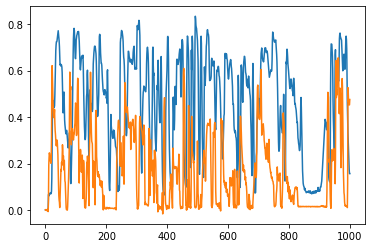

In [50]:
%matplotlib inline
X = range(0,1000)
Y = range(35, 1035)
plt.plot(X, predictors_concatenated[0].x[X]/2000)
plt.plot(X, aud_concatenated.x[0][Y])

plt.show()

<IPython.core.display.Javascript object>


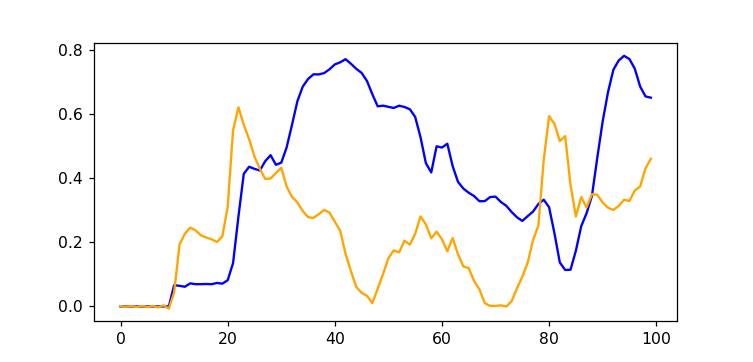

In [41]:
%matplotlib notebook
X = range(0,100)
Y = range(35, 135)
plt.plot(X, predictors_concatenated[0].x[X]/2000, color='blue')
plt.plot(X, resp_concatenated.x[0][Y], color='orange')

plt.show()